# 請研究下面的連結理解RNN概念

# [Keras 利用Keras建構LSTM模型，以Stock Prediction 為例 1](https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b)

In [1]:
import os
os.environ['keras_backend']='tensorflow'
import gc

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Many to One LSTM model for stock prediction 

<img src="./data/rnn.JPG">

In [2]:
def readData():
#     train = pd.read_csv('data/msisdn_dealer_id 3301001.csv')
    f= open("data/STOCK_DAY.csv")   #元大台灣ETF50
    train = pd.read_csv(f)    
    return train

def augFeatures(train):
    train['apply_date'] = pd.to_datetime(train['apply_date'])
    train['year'] = train['apply_date'].dt.year
    train['month'] = train['apply_date'].dt.month
    train['day'] = train['apply_date'].dt.day
    train['dow'] = train['apply_date'].dt.dayofweek
    train['woy'] = train['apply_date'].dt.weekofyear
    return train

def augFeatureszh(train):
    train['日期'] = pd.to_datetime(train['日期'])
    train['year'] = train['日期'].dt.year
    train['month'] = train['日期'].dt.month
    train['day'] = train['日期'].dt.day
    train['dow'] = train['日期'].dt.dayofweek
    train['woy'] = train['日期'].dt.weekofyear
    train['apply_date'] = train['日期']
    train['volume'] = pd.to_numeric(train['成交股數'].str.replace(',', ''))
    train['amount'] = pd.to_numeric(train['成交金額'].str.replace(',', ''))
    train['open'] = train['開盤價']
    train['high'] = train['最高價']
    train['low'] = train['最低價']
    train['close'] = train['收盤價']
    train['diffprice'] = pd.to_numeric(train['漲跌價差'].str.replace('X0.00', '0.00'))
    train['dealcnt'] = pd.to_numeric(train['成交筆數'].str.replace(',', ''))
    return train

def trainDrop(train):
    train = train.drop(['日期'], axis=1)
    train = train.drop(['空白'], axis=1)
    train = train.drop(['成交股數'], axis=1)
    train = train.drop(['成交金額'], axis=1)
    train = train.drop(['開盤價'], axis=1)
    train = train.drop(['最高價'], axis=1)
    train = train.drop(['最低價'], axis=1)
    train = train.drop(['收盤價'], axis=1)
    train = train.drop(['漲跌價差'], axis=1)
    train = train.drop(['成交筆數'], axis=1)
#     train = train.drop(['diffprice'], axis=1)
    return train

def normalize(train):
    train = train.drop(['apply_date'], axis=1)
#     train = train.drop(['msisdn_dealer_id'], axis=1) # 同店
#     train = train.drop(['year'], axis=1) #不管年
#     train = train.drop(['woy'], axis=1) #不管年週
#     train = train.drop(['month'], axis=1) #不管月
#     train = train.drop(['day'], axis=1) #不管日   
#     train = train.drop(['cust_in_cnt'], axis=1) #不看進店數
    train_norm = train.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)))
    train_mean, train_max, train_min = np.mean(train), np.max(train), np.min(train) # for 還原 pred_y 用的
    return train_norm, train_mean, train_max, train_min

def buildTrain(train, pastDay=7, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]['close']))
    return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
    np.random.seed(33)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [3]:
train = readData()
train_aug = augFeatureszh(train)
train_aug = trainDrop(train_aug)

In [4]:
train_aug.head(3)
# type(train_aug['diffprice'][0]) , type(train_aug['close'][0])
# pd.to_numeric(train_aug['volume'])

,year,month,day,dow,woy,apply_date,volume,amount,open,high,low,close,diffprice,dealcnt
0,2018,11,1,3,44,2018-11-01,6807294,532547148,77.85,78.45,77.55,78.40,0.85,3048
1,2018,11,2,4,44,2018-11-02,6722329,527356465,78.40,78.80,78.00,78.65,0.25,3073
2,2018,11,5,0,45,2018-11-05,4657750,363054360,78.10,78.25,77.60,78.25,-0.40,2195


In [5]:
# train = readData()
# train_aug = augFeatures(train)
# print(train_aug.head(1))

In [6]:
# print(np.sort(train_aug.close.unique()))
print(len(train_aug.close.unique()))

233


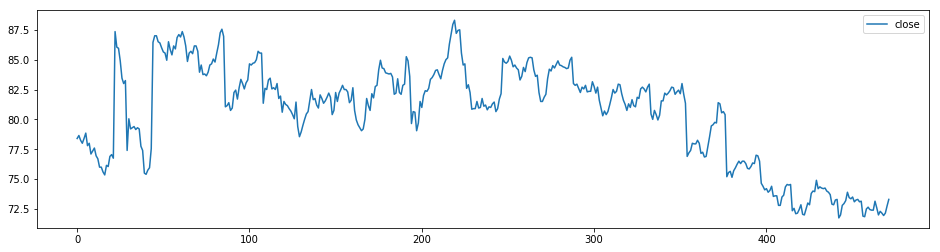

In [7]:
plt.figure(figsize=(16,4))
plt.plot(train_aug['close'], label='close')
plt.legend()
plt.show()

In [8]:
train_norm, train_mean, train_max, train_min = normalize(train_aug)
# train_norm['sales'] =  train_aug['sales']
train_norm.head(3)

,year,month,day,dow,woy,volume,amount,open,high,low,close,diffprice,dealcnt
0,0.521186,0.415639,-0.494915,0.186017,0.348704,0.017334,0.014836,-0.161989,-0.142565,-0.157913,-0.127714,0.097682,0.035898
1,0.521186,0.415639,-0.461582,0.386017,0.348704,0.016079,0.013861,-0.128350,-0.121353,-0.130722,-0.112608,0.027094,0.036750
2,0.521186,0.415639,-0.361582,-0.413983,0.368312,-0.014398,-0.017018,-0.146698,-0.154687,-0.154891,-0.136777,-0.049377,0.006813


In [9]:
# train_norm = train_aug.drop(['apply_date'], axis=1)
# train_norm = train_norm.drop(['year'], axis=1)
# train_norm = train_norm.drop(['month'], axis=1)
# train_norm = train_norm.drop(['day'], axis=1)
# train_norm = train_norm.drop(['woy'], axis=1)
# train_norm = train_norm.drop(['cust_in_cnt'], axis=1)
# train_norm = train_norm.drop(['emp_cnt'], axis=1)
# train_norm = train_norm.drop(['prj_cnt'], axis=1)
X_train, Y_train = buildTrain(train_norm)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((418, 7, 13), (418, 1), (46, 7, 13), (46, 1))

In [10]:
X_train[1][0], Y_train[1] # , X_val[0], Y_val[0]

(array([ 0.52118644, -0.49345146, -0.22824859, -0.21398305, -0.47482552,
        -0.02905688, -0.02735365,  0.22027419,  0.20894967,  0.22577321,
         0.21971811,  0.00356431, -0.02234032]), array([0.34962748]))

In [11]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(28, input_shape=(shape[1], shape[2])))
#     model.add(LSTM(4, input_length=shape[1], input_dim=shape[2]))
    # output shape : (1,1)
    model.add(Dense(1))
#     model.add(Dense(29, activation='softmax'))
    model.compile(loss='mse', optimizer='Adam')  # sparse_categorical_crossentropy
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])    
    model.summary()
    return model

In [12]:
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor='loss', patience=20, verbose=0, mode='auto')
manytoonehist = model.fit(X_train, Y_train, epochs=1000, batch_size=12, 
                          validation_data=(X_val, Y_val), callbacks=[callback], verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 29        
Total params: 4,733
Trainable params: 4,733
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 418 samples, validate on 46 samples
Epoch 1/1000
418/418 [==============================] - 2s 5ms/step - loss: 0.0278 - val_loss: 0.0087
Epoch 2/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0043
Epoch 3/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0049
Epoch 4/1000
418/418 [==============================] - 1s 1ms/st

418/418 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 69/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 70/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 71/1000
418/418 [==============================] - 0s 997us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 72/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 73/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 74/1000
418/418 [==============================] - 0s 983us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 75/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 76/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 77/1000
418/418 [==============================] - 0s 983us/step - loss: 0.00

Epoch 147/1000
418/418 [==============================] - 0s 988us/step - loss: 0.0019 - val_loss: 0.0036
Epoch 148/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 149/1000
418/418 [==============================] - 0s 955us/step - loss: 0.0019 - val_loss: 0.0034
Epoch 150/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 151/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 152/1000
418/418 [==============================] - 0s 977us/step - loss: 0.0019 - val_loss: 0.0033
Epoch 153/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 154/1000
418/418 [==============================] - 0s 999us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 155/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 156/1000
418/418 [==============================] 

418/418 [==============================] - 0s 987us/step - loss: 0.0011 - val_loss: 0.0031
Epoch 226/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 227/1000
418/418 [==============================] - 0s 989us/step - loss: 0.0012 - val_loss: 0.0029
Epoch 228/1000
418/418 [==============================] - 0s 984us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 229/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 230/1000
418/418 [==============================] - 0s 995us/step - loss: 9.9073e-04 - val_loss: 0.0027
Epoch 231/1000
418/418 [==============================] - 0s 1ms/step - loss: 9.6306e-04 - val_loss: 0.0029
Epoch 232/1000
418/418 [==============================] - 0s 1ms/step - loss: 9.8532e-04 - val_loss: 0.0028
Epoch 233/1000
418/418 [==============================] - 0s 991us/step - loss: 9.7769e-04 - val_loss: 0.0027
Epoch 234/1000
418/418 [=============================

Epoch 301/1000
418/418 [==============================] - 0s 1ms/step - loss: 7.0833e-04 - val_loss: 0.0032
Epoch 302/1000
418/418 [==============================] - 0s 1ms/step - loss: 6.5993e-04 - val_loss: 0.0033
Epoch 303/1000
418/418 [==============================] - 0s 987us/step - loss: 6.7172e-04 - val_loss: 0.0031
Epoch 304/1000
418/418 [==============================] - 0s 1ms/step - loss: 7.3472e-04 - val_loss: 0.0034
Epoch 305/1000
418/418 [==============================] - 0s 1ms/step - loss: 7.1787e-04 - val_loss: 0.0033
Epoch 306/1000
418/418 [==============================] - 0s 1ms/step - loss: 6.3086e-04 - val_loss: 0.0033
Epoch 307/1000
418/418 [==============================] - 0s 1ms/step - loss: 6.3159e-04 - val_loss: 0.0034
Epoch 308/1000
418/418 [==============================] - 0s 971us/step - loss: 7.1296e-04 - val_loss: 0.0034
Epoch 309/1000
418/418 [==============================] - 0s 952us/step - loss: 7.0247e-04 - val_loss: 0.0033
Epoch 310/1000
418/418

418/418 [==============================] - 0s 980us/step - loss: 0.0018 - val_loss: 0.0037
Epoch 377/1000
418/418 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 378/1000
418/418 [==============================] - 0s 1ms/step - loss: 9.3990e-04 - val_loss: 0.0038
Epoch 379/1000
418/418 [==============================] - 0s 996us/step - loss: 0.0010 - val_loss: 0.0036
Epoch 380/1000
418/418 [==============================] - 0s 1ms/step - loss: 6.4285e-04 - val_loss: 0.0035
Epoch 381/1000
418/418 [==============================] - 0s 1ms/step - loss: 5.3061e-04 - val_loss: 0.0036
Epoch 382/1000
418/418 [==============================] - 0s 989us/step - loss: 4.8231e-04 - val_loss: 0.0035
Epoch 383/1000
418/418 [==============================] - 0s 1ms/step - loss: 4.4598e-04 - val_loss: 0.0037
Epoch 384/1000
418/418 [==============================] - 0s 999us/step - loss: 4.4824e-04 - val_loss: 0.0037
Epoch 385/1000
418/418 [=======================

## loss trend chart

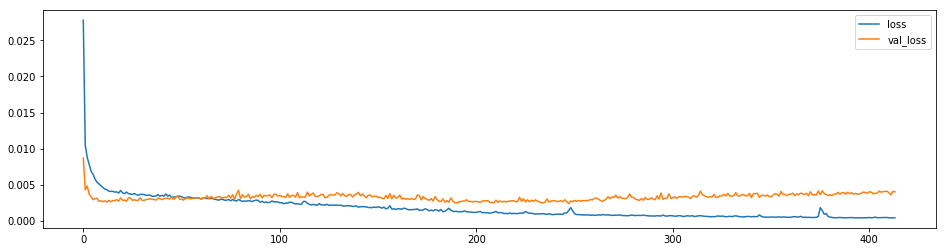

In [13]:
plt.figure(figsize=(16,4))
plt.plot(manytoonehist.history['loss'], label='loss')
plt.plot(manytoonehist.history['val_loss'], label='val_loss')
# plt.plot(manytoonehist.history['acc'], label='acc')
# plt.plot(manytoonehist.history['val_acc'], label='val_acc')
# plt.plot(np.sqrt(np.square(dif_pred)), label='dif_pred')
plt.legend()
plt.show()

In [14]:
# plt.figure(figsize=(16,7))
# plt.plot(manytoonehist.history['loss'], label='loss')
# plt.plot(manytoonehist.history['val_loss'], label='val_loss')
# # plt.plot(manytoonehist.history['acc'], label='acc')
# # plt.plot(manytoonehist.history['val_acc'], label='val_acc')
# # plt.plot(np.sqrt(np.square(dif_pred)), label='dif_pred')
# plt.legend()
# plt.show()

In [15]:
y_pred = model.predict(X_val, batch_size=128, verbose=1, steps=None)
print(y_pred[0])

46/46 [==============================] - 0s 2ms/step
[0.09661064]


In [16]:
y_result = y_pred * (train_max['close']-train_min['close']) + train_mean['close']
Y_val_rev = Y_val * (train_max['close']-train_min['close']) + train_mean['close']
dif_pred = Y_val_rev - y_result
type(Y_val_rev),type(y_result)
# y_result = y_pred #  * (train_max['sales']-train_min['sales']) + train_mean['sales']
# Y_val_rev = Y_val # * (train_max['sales']-train_min['sales']) + train_mean['sales']
# dif_pred = Y_val_rev - y_result

(numpy.ndarray, numpy.ndarray)

In [17]:
# np.set_printoptions(precision=2)

In [18]:
y_result[1], Y_val_rev[1], dif_pred[1]

(array([84.575806], dtype=float32), array([84.6]), array([0.02419434]))

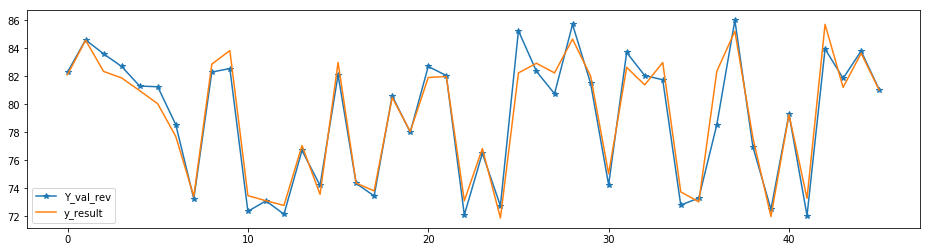

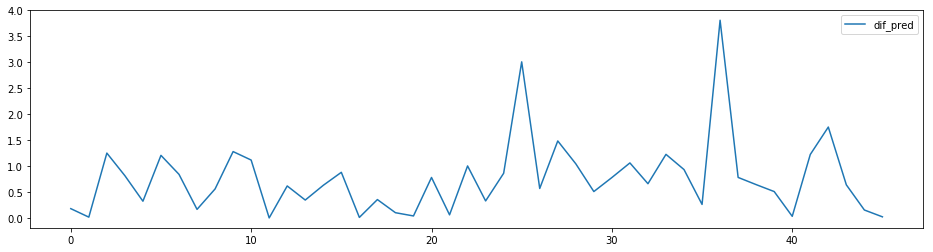

In [19]:
plt.figure(figsize=(16,4))
plt.plot(Y_val_rev, label='Y_val_rev', marker='*')
plt.plot(y_result, label='y_result')
# plt.plot(np.sqrt(np.square(dif_pred)), label='dif_pred')
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
# plt.plot(Y_val_rev, label='Y_val_rev', marker='*')
# plt.plot(y_result, label='y_result')
plt.plot(np.sqrt(np.square(dif_pred)), label='dif_pred')
plt.legend()
plt.show()

In [20]:
y_train_pred = model.predict(X_train, batch_size=300, verbose=1, steps=None)
y_train_pred[0]

418/418 [==============================] - 0s 67us/step


array([0.26371384], dtype=float32)

In [21]:
y_train_result = y_train_pred  * (train_max['close']-train_min['close']) + train_mean['close']
Y_train_rev = Y_train   * (train_max['close']-train_min['close']) + train_mean['close']
dif_train_pred = (Y_train_rev - y_train_result)
y_train_result[0:3], Y_train_rev[0:3], dif_train_pred[0:3]


# y_train_result = y_train_pred  #* (train_max['sales']-train_min['sales']) + train_mean['sales']
# Y_train_rev = Y_train   #* (train_max['sales']-train_min['sales']) + train_mean['sales']
# dif_train_pred = Y_train_rev - y_train_result
# y_train_result[0:3], Y_train_rev[0:3], dif_train_pred[0:3]

(array([[84.87813 ],
        [85.728836],
        [87.12141 ]], dtype=float32), array([[85.1 ],
        [86.3 ],
        [87.25]]), array([[0.22187195],
        [0.57116394],
        [0.12859344]]))

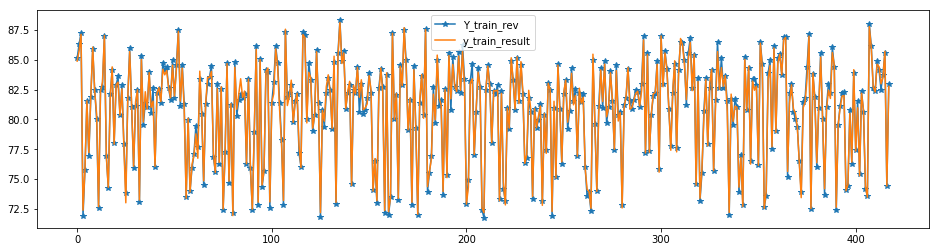

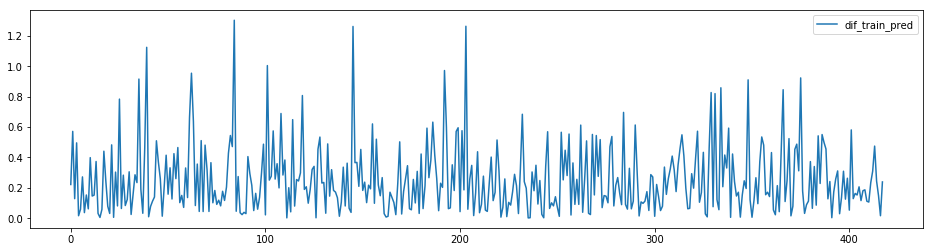

In [22]:
plt.figure(figsize=(16,4))
plt.plot(Y_train_rev, label='Y_train_rev', marker='*')
plt.plot(y_train_result, label='y_train_result')
# plt.plot(np.sqrt(np.square(dif_train_pred)), label='dif_train_pred')
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
# plt.plot(Y_train_rev, label='Y_train_rev', marker='*')
# plt.plot(y_train_result, label='y_train_result')
plt.plot(np.sqrt(np.square(dif_train_pred)), label='dif_train_pred')
plt.legend()
plt.show()

In [23]:
# 決定係數評價指標
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %
      (r2_score(Y_train, y_train_pred)*100,
      r2_score(Y_val, y_pred)*100))

R^2 train: 99.317, test: 94.489


In [24]:
del(model)

In [25]:
gc.collect()

12339